In [1]:
from plato.environment import Environment

In [2]:
config = {
  "whites":{
    "params":{
    "n_white_infantry":7,
    "n_white_vehicle":2,
    "n_white_drone":1},
    "init":"SE"
  },

  "blacks":{
    "params":{
    "n_black_infantry":7,
    "n_black_vehicle":2,
    "n_black_drone":1},
    "init":"NW"
  }
}

In [3]:
sim = Environment(config, shape=(64,64), time_limit=2**5)

In [4]:
obs = sim.reset()

In [5]:
from plato.objective.spatiotemporal.surveil_objective import SurveilObjective
sim.objectives = [SurveilObjective(targets=sim.blacks.values())]

In [6]:
minimap = sim.observation(sim.whites, negative=None)
minimap.shape

(25, 64, 64)

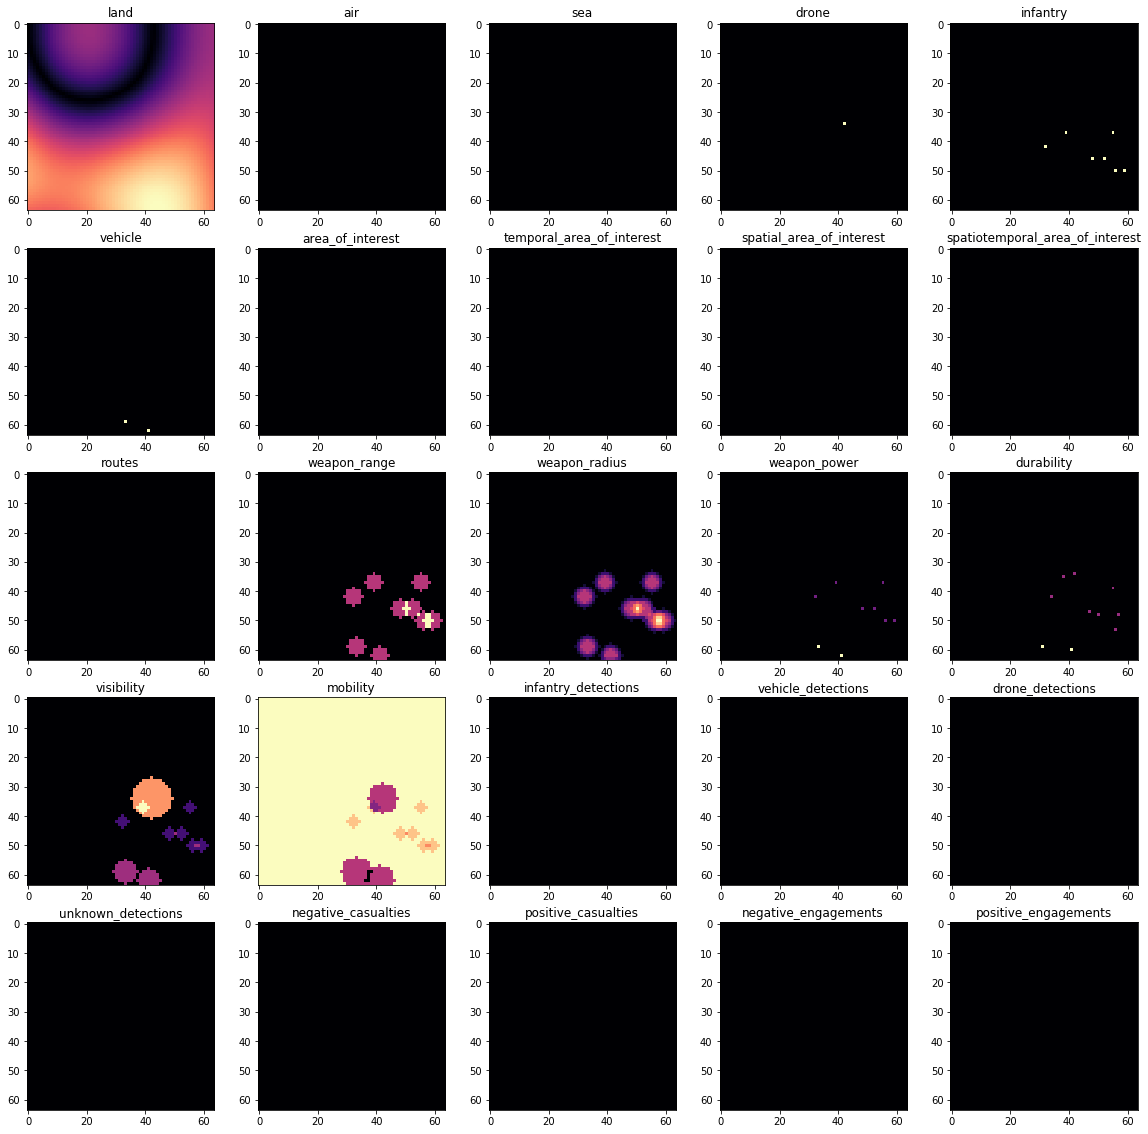

In [7]:
import numpy as np, matplotlib.pyplot as mp
from plato.features import global_features
fig,ax = mp.subplots(5,5, figsize=(20,20))
for itr,(name,feat) in enumerate(zip(global_features, minimap)):
    i,j = np.unravel_index(itr,(5,5))
    ax[i,j].set_title(name)
    ax[i,j].imshow(feat, cmap='magma')
mp.show()

In [8]:
import torch as th
class EntityTypeController(th.nn.Module):
    def __init__(self, inch, ouch, nonlin=th.nn.LeakyReLU(2e-1)):
        super().__init__()   
        self.inch, self.ouch = inch, ouch
        self.encoder = th.nn.ModuleList([
        th.nn.Conv2d(inch, 16, 7, 3), nonlin,
        th.nn.Conv2d(  16, 32, 5, 3), nonlin,
        th.nn.Conv2d(  32, 64, 3, 2), nonlin])
        
        self.output = th.nn.Sequential(
        th.nn.Linear(self.features(), 256),
        nonlin,
        th.nn.Dropout(0.1),
        th.nn.Linear(256, ouch))
        
    def features(self):
        x = th.randn((1,self.inch,64,64))
        for layer in self.encoder: x = layer(x)
        return x.view(1,-1).size(-1)
    
    def __call__(self, x, verbose=False):
        for layer in self.encoder:
            x = layer(x)
            if verbose: print(x.size())
        x = x.view(-1)
        if verbose: print(x.size())
        y = self.output(x)
        if verbose: print(y.size())
        return y

In [9]:
import random
infantry_entity = random.choice([ent for ent in list(sim.whites.values()) if ent.entity_type == 'infantry'])
infantry_controller = EntityTypeController(minimap.shape[0], infantry_entity.n_actions)
infantry_controller

EntityTypeController(
  (encoder): ModuleList(
    (0): Conv2d(25, 16, kernel_size=(7, 7), stride=(3, 3))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(3, 3))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.2)
  )
  (output): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=42, bias=True)
  )
)

In [10]:
infantry_controller(th.randn(1,*minimap.shape), verbose=True)

torch.Size([1, 16, 20, 20])
torch.Size([1, 16, 20, 20])
torch.Size([1, 32, 6, 6])
torch.Size([1, 32, 6, 6])
torch.Size([1, 64, 2, 2])
torch.Size([1, 64, 2, 2])
torch.Size([256])
torch.Size([42])


tensor([ 0.0209, -0.0345, -0.0909,  0.0299, -0.0206, -0.0591,  0.0053, -0.0084,
        -0.0105, -0.0266,  0.0089, -0.0364,  0.0687,  0.0444,  0.1039,  0.0321,
         0.0410, -0.0361,  0.0308, -0.0337,  0.0218,  0.0671, -0.0006,  0.0572,
         0.0281, -0.0414, -0.0263,  0.0552,  0.0364,  0.0167,  0.0448, -0.0718,
         0.0200, -0.0155, -0.0138,  0.0110, -0.0496,  0.0134,  0.0275,  0.0300,
         0.0664,  0.0264], grad_fn=<AddBackward0>)

In [11]:
import collections
class Memory(object):
    def __init__(self, capacity=1):
        self.wipe(capacity)
        
    def wipe(self, capacity=1):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, sprime, aprime, terminal):
        state  = np.asarray(state).astype(np.float32)
        action = np.asarray(action).astype(np.float32)
        reward = np.asarray(reward).astype(np.float32)
        sprime = np.asarray(sprime).astype(np.float32)
        aprime = np.asarray(aprime).astype(np.float32)
        terminal = np.asarray(terminal).astype(np.float32)
        self.buffer.append((state, action, reward, sprime, aprime, terminal))

    def save(self, saver):
        np.save(saver, np.asarray(self.buffer))

    def sample(self, bsize=1):
        s,a,r,s_,a_,t = zip(*random.sample(self.buffer, bsize))
        return np.array(s), np.array(a), np.array(r), np.array(s_), np.array(a_), np.array(t)

    def __len__(self):
        return len(self.buffer)

In [12]:
class Controller(object):
    def __init__(self, n_actions, entity_type):
        super().__init__()
        self.policy = lambda logits:logits.max(-1)[1]
        self.memory = Memory()
        self.infantry_controller = EntityTypeController(1 + minimap.shape[0], n_actions)
        self.filter_entities= lambda entities:{id:ent for id,ent in entities.items() if ent.entity_type == entity_type and ent.operational}
        self.filter_actions = lambda entities:{id:ent.random_action() for id,ent in entities.items()}
    
    def localize_observation(self, entity):
        identity = np.zeros((*minimap.shape[1:],))
        identity[entity.xy[0],entity.xy[1]] = 1
        identity = np.expand_dims(identity,axis=0)
        return np.concatenate([identity, minimap],axis=0)
            
    def retain(self,s,entities,a,r,s_,entities_,a_,t):
        entities = self.filter_entities(entities)
        entities_= self.filter_entities(entities_)
        for (entity,action,entity_,aprime) in zip(entities.values(),a.values(),entities_.values(),a_.values()):
            s = self.localize_observation(entity)
            s_= self.localize_observation(entity_)
            self.memory.push(s,action,r,s_,aprime,t)
        
    def __call__(self, entities, minimap, damage_map, verbose=False):
        self.drones = self.filter_entities(entities)
        actions = self.filter_actions(entities)

        for id_,drone in self.drones.items():
            x = self.localize_observation(drone)
            x = th.from_numpy(x).float().unsqueeze(0)
            logits = self.drone_controller(x)
            actions[id_] = self.policy(logits)
            
            if actions[id_] in entities[id_].patrol_action_space:
                spatial_action = self.localize(entity)
            if actions[id_] in entities[id_].attack_action_space:
                spatial_action = damage_map
        
        return action, spatial_action
controller = Controller(infantry_entity.n_actions, 'infantry')

In [13]:
import torch as th
from torch.autograd import Variable

lossf = th.nn.SmoothL1Loss()
optim = th.optim.Adam(controller.infantry_controller.parameters(), amsgrad=True)

def on_policy(s,a,r,s_,a_,t):
    s = th.from_numpy(s).float()
    a = th.from_numpy(a).float()
    r = th.from_numpy(r).float()
    s_= th.from_numpy(s_).float()
    a_= th.from_numpy(a_).float()
    t = th.from_numpy(t).float()
    
    optim.zero_grad()

    Qvalue = controller.infantry_controller( s)
    Qvalue = Qvalue.unsqueeze(0)

    Qprime = controller.infantry_controller(s_)
    Qprime = Qprime.unsqueeze(0)
        
    Qvalue = Qvalue.gather(1, a.unsqueeze(1).long()).squeeze(1)
    Qprime = Qprime.gather(1,a_.unsqueeze(1).long()).squeeze(1)

    Qvalue = Variable(Qvalue, requires_grad=True)
    Qprime = Variable(Qprime, requires_grad=False)

    Qexpect = r + 9e-1 * Qprime * (1 - t)

    loss = lossf(Qvalue, Qexpect)

    loss.backward()

    optim.step()
    return loss.item()

In [15]:
import copy, tqdm
sim.reset()
bar = tqdm.tqdm_notebook(total=sim.time_limit)

loss = None
actions = None
terminal = False
while not terminal:
    entities,enemies = copy.deepcopy(sim.whites), sim.blacks
    aprimes = {id:ent.random_action() for id,ent in entities.items() if ent.operational}
    enemies = {id:ent.random_action() for id,ent in enemies.items() if ent.operational}

    state = sim.observation(sim.whites)
    sprime, reward, terminal, metadata = sim.step(aprimes, enemies)
    
    if actions is not None:
        controller.retain(state, entities, actions, reward, sprime, sim.whites, aprimes, terminal)
        s,a,r,s_,a_,t = controller.memory.sample(bsize=1)

        loss = on_policy(s,a,r,s_,a_,t)
        controller.memory.wipe()
        
    state,actions = sprime,aprimes

    bar.update(1)
    if loss: bar.set_description('Loss: {:.8f}'.format(loss))